- https://arxiv.org/pdf/1811.03575.pdf

In [1]:
import keras
from keras.datasets.cifar10 import load_data
import numpy as np
from unittest import mock

(X_train, y_train), (X_test, y_test) = load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_test.mean(axis=0)) / X_train.std(axis=0)

y_train = keras.utils.to_categorical(y_train, 10)
y_train = y_train[:, np.newaxis, :]
y_test = keras.utils.to_categorical(y_test, 10)
y_test = y_test[:, np.newaxis, :]

Using TensorFlow backend.


In [2]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1, 10))

In [3]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1, 10))

# Deep probabalistic ensembles

In [4]:
import keras
import keras.backend as K
from resnet import ResNet
import numpy as np


def kl_regularization(layers):
    layers = K.stack(layers, axis=0)
    layer_dims = K.cast_to_floatx(K.int_shape(layers[0]))
    n_w = layer_dims[0]
    n_h = layer_dims[1]
    n_o = layer_dims[3]
    mu_i = K.mean(layers, axis=0)
    var_q_i = K.var(layers, axis=0)
    var_p_i = 2 / (n_w * n_h * n_o)
    kl_i = K.log(var_q_i) + (var_p_i / var_q_i) + (mu_i**2 / var_q_i)
    return K.sum(kl_i)


def ensemble_crossentropy(y_true, y_pred):
    ensemble_entropy = K.categorical_crossentropy(y_true, y_pred, axis=-1)
    return K.sum(ensemble_entropy, axis=-1)


class Stack(keras.layers.Layer):
    def call(self, X):
        return K.stack(X, axis=1)
    
    def compute_output_shape(self, input_shape):
        # assumes all input shapes are the same
        return (input_shape[0][0], len(input_shape), input_shape[0][1])


class DeepProbabalisticEnsemble(keras.models.Model):
    def __init__(self, input_shape, n_classes, n_members, beta=10**-5):
        # build ensemble
        # instantiate the first member of the ensemble so we can reuse its input layer
        # with the other layers
        self.members = [ResNet(input_shape, classes=n_classes, block='basic', repetitions=[2, 2, 2, 2])]
        self.members += [ResNet((32, 32, 3), classes=10, block='basic', input_layer=self.members[0].inputs[0],
                                repetitions=[2, 2, 2, 2])
                         for _ in range(n_members-1)]
        outputs = Stack()([m.output for m in self.members])
        self.beta = beta
        super().__init__(inputs=self.members[0].inputs, outputs=outputs)
    
    @property
    def losses(self):
        losses = super().losses

        # compute KL regularization
        conv_layers = [
            # kernel is index 0, bias is index 1
            [L.trainable_weights[0] for L in m.layers if isinstance(L, keras.layers.Conv2D)]
            for m in self.members]
        # currently, each sublist is a list of model layers.
        # realign these sublists to correspond to layers
        conv_layers = [[L for L in layers] for layers in zip(*conv_layers)]
        kl_regularizations = [self.beta * kl_regularization(layers) for layers in conv_layers]
        losses.extend(kl_regularizations)

        return losses


def simulate_active_learning(dpe, X_train, y_train, validation_data, budget, n_iterations=8, max_epochs=400):
    b = budget // n_iterations
    n_acquisitions = b
    idx = np.random.choice(len(X_train), size=len(X_train), replace=False)
    X_labeled, y_labeled = X_train[idx[:b]], y_train[idx[:b]]
    X_unlabeled, y_unlabeled = X_train[idx[b:]], y_train[idx[b:]]
    while n_acquisitions < budget:
        dpe.fit(
            X_labeled, y_labeled,
            batch_size=32,
            epochs=max_epochs,
            validation_data=validation_data,
            callbacks=[keras.callbacks.ReduceLROnPlateau(patience=25)])
        # aggregate along the individual model predictions
        h_ens = dpe.predict(X_unlabeled).sum(axis=1)
        idx_acquisitions = np.argsort(h_ens)[-b:]
        idx_rest = np.argsort(h_ens)[:-b]
        X_labeled = np.concatenate([X_labeled, X_unlabeled[idx_acquisitions]])
        y_labeled = np.concatenate([y_labeled, y_labeled[idx_acquisitions]])
        X_unlabeled = X_unlabeled(idx_rest)
        n_acquisitions += b
    return (X_labeled, y_labeled), (X_unlabeled, y_unlabeled)

In [5]:
dpe = DeepProbabalisticEnsemble((32, 32, 3), 10, 8)

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


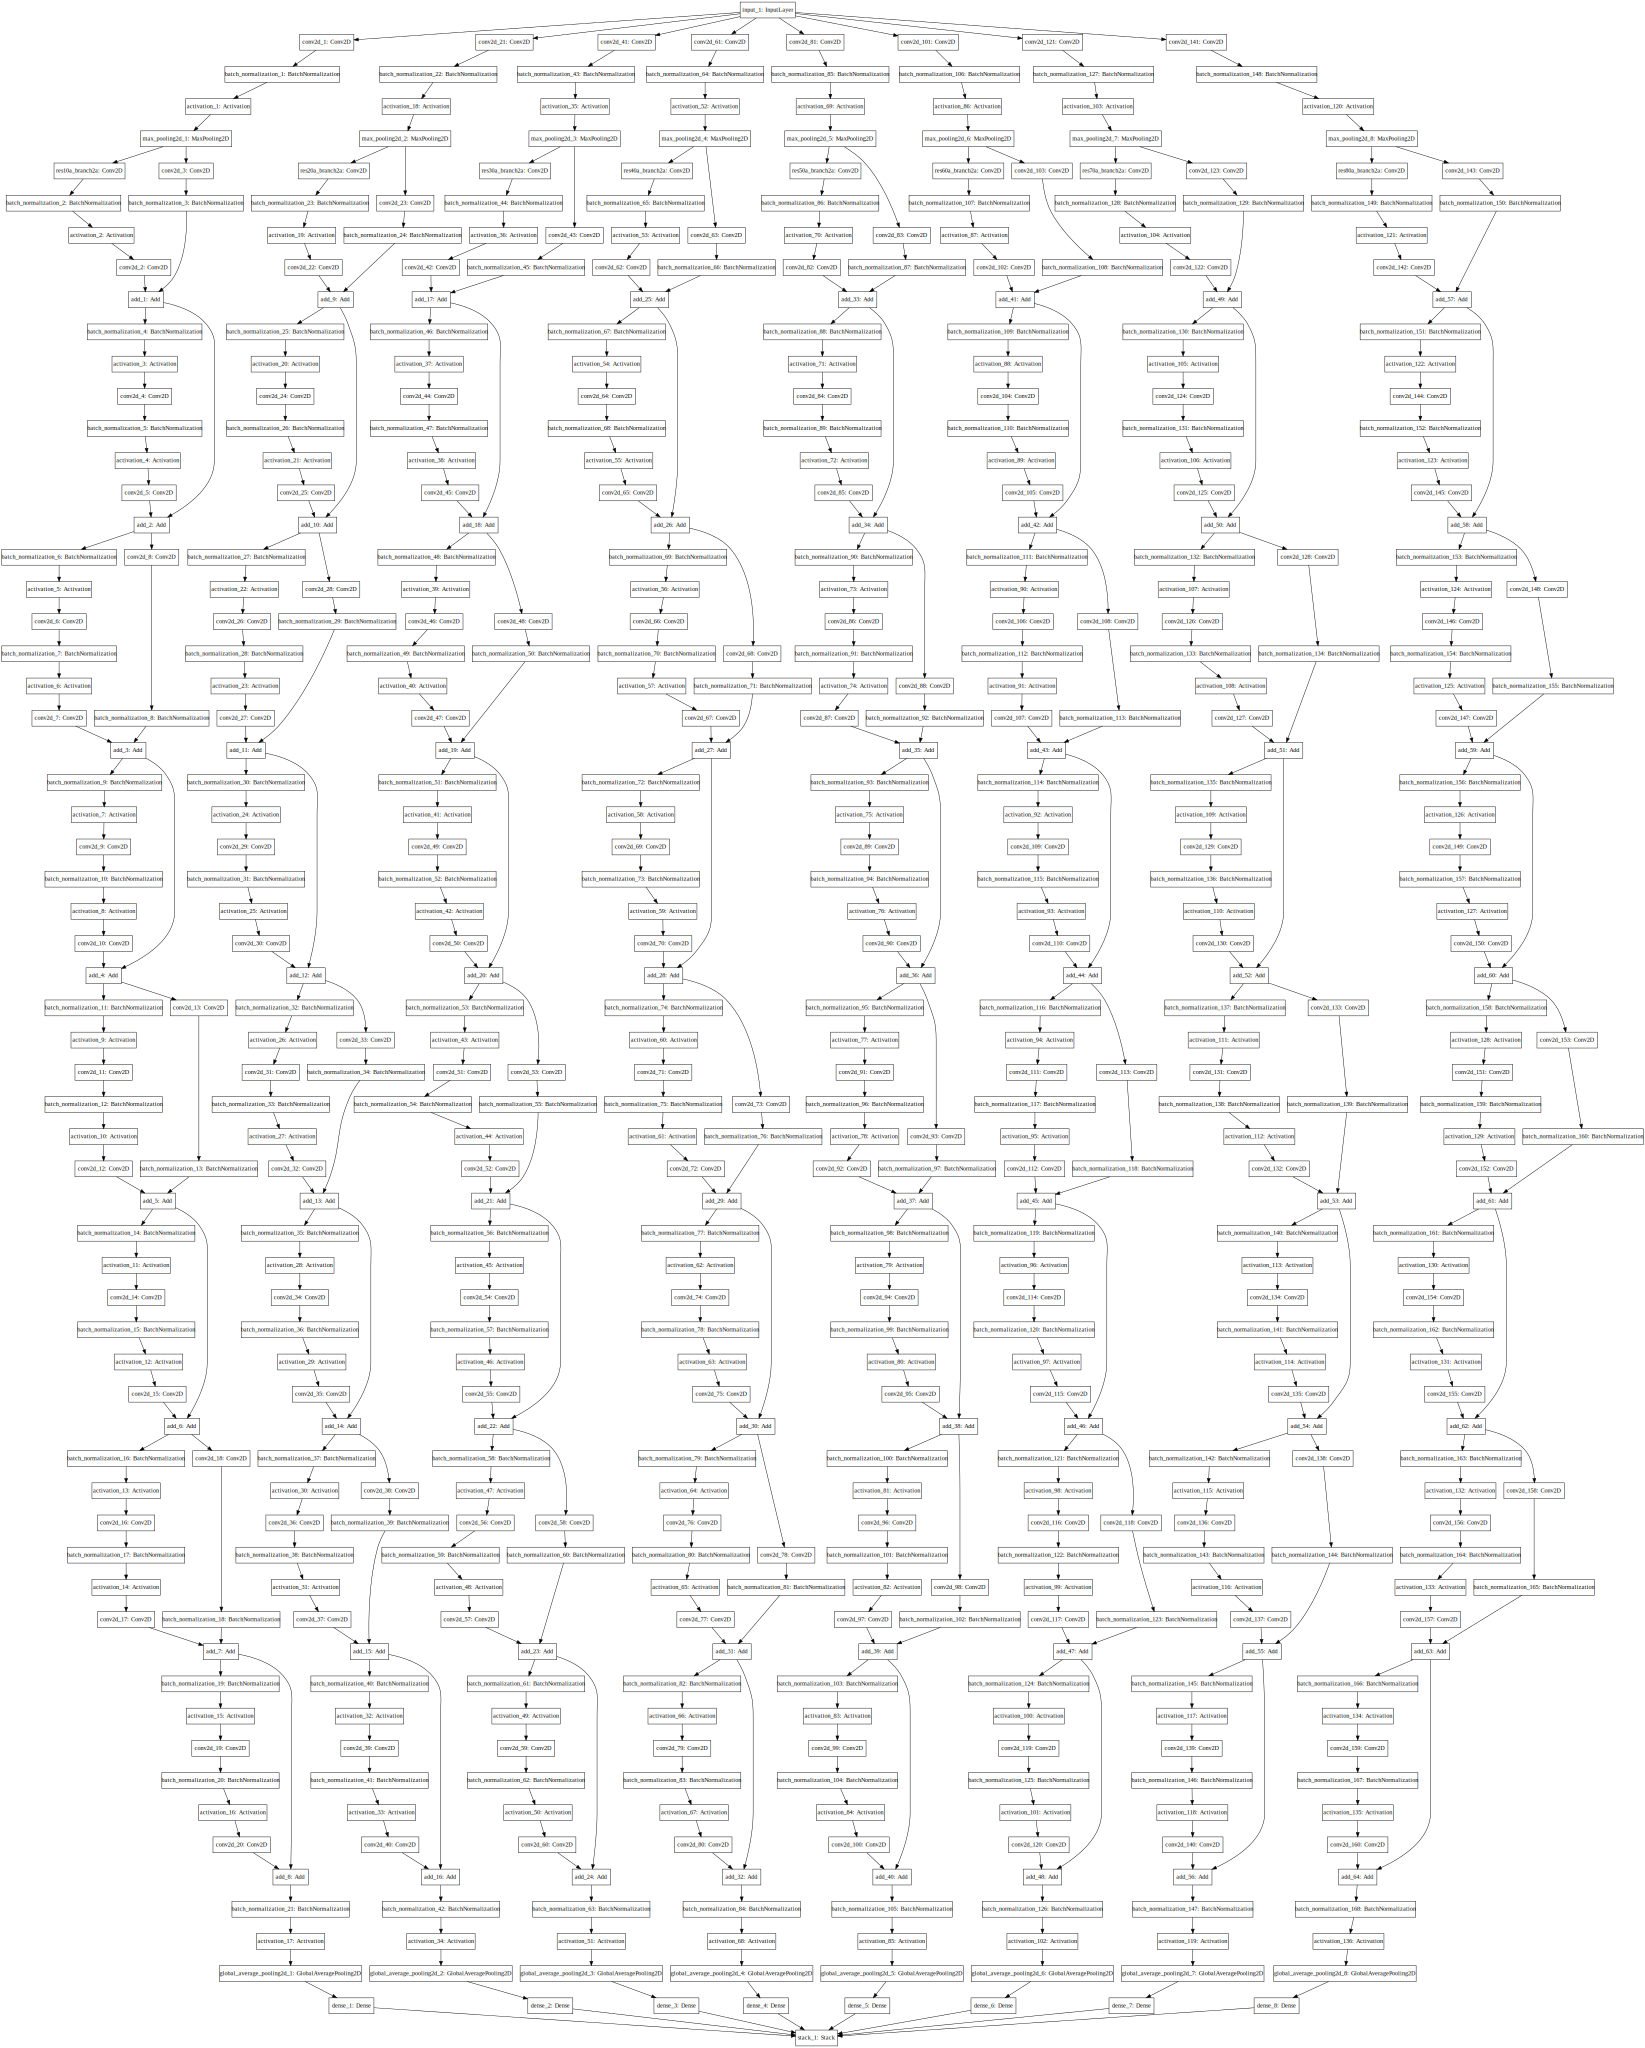

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(dpe).create(prog='dot', format='svg'))

In [7]:
dpe.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_61 

In [ ]:
dpe.compile(loss=ensemble_crossentropy, optimizer='adam', metrics=['accuracy'])
data = simulate_active_learning(dpe, X_train, y_train, (X_test, y_test), budget=4000)

Train on 500 samples, validate on 10000 samples
Epoch 1/400
500/500 [==============================] - 97s 194ms/step - loss: -675.4278 - acc: 0.2440 - val_loss: -596.1344 - val_acc: 0.1395
Epoch 2/400
500/500 [==============================] - 35s 70ms/step - loss: -700.1143 - acc: 0.6623 - val_loss: -600.7388 - val_acc: 0.1510
Epoch 3/400
500/500 [==============================] - 35s 71ms/step - loss: -707.1822 - acc: 0.8832 - val_loss: -604.9699 - val_acc: 0.1715
Epoch 4/400
500/500 [==============================] - 35s 70ms/step - loss: -709.6588 - acc: 0.9475 - val_loss: -602.1171 - val_acc: 0.1467
Epoch 5/400
500/500 [==============================] - 35s 71ms/step - loss: -710.5295 - acc: 0.9557 - val_loss: -606.3723 - val_acc: 0.1742
Epoch 6/400
500/500 [==============================] - 35s 70ms/step - loss: -711.2941 - acc: 0.9705 - val_loss: -605.5975 - val_acc: 0.1660
Epoch 7/400
500/500 [==============================] - 35s 71ms/step - loss: -711.4090 - acc: 0.9615 - va

500/500 [==============================] - 35s 71ms/step - loss: -715.3882 - acc: 0.9823 - val_loss: -612.4391 - val_acc: 0.1917
Epoch 59/400
500/500 [==============================] - 35s 71ms/step - loss: -715.3625 - acc: 0.9800 - val_loss: -612.0026 - val_acc: 0.1884
Epoch 60/400
500/500 [==============================] - 35s 70ms/step - loss: -715.4498 - acc: 0.9818 - val_loss: -611.8123 - val_acc: 0.1875
Epoch 61/400
500/500 [==============================] - 35s 71ms/step - loss: -715.4461 - acc: 0.9815 - val_loss: -610.4871 - val_acc: 0.1769
Epoch 62/400
500/500 [==============================] - 35s 71ms/step - loss: -715.3040 - acc: 0.9797 - val_loss: -612.2922 - val_acc: 0.1892
Epoch 63/400
500/500 [==============================] - 35s 71ms/step - loss: -715.4075 - acc: 0.9775 - val_loss: -611.3378 - val_acc: 0.1818
Epoch 64/400
500/500 [==============================] - 35s 71ms/step - loss: -715.4981 - acc: 0.9825 - val_loss: -611.2918 - val_acc: 0.1823
Epoch 65/400
500/50

Epoch 116/400
500/500 [==============================] - 35s 71ms/step - loss: -716.4938 - acc: 1.0000 - val_loss: -615.9417 - val_acc: 0.2117
Epoch 117/400
500/500 [==============================] - 35s 71ms/step - loss: -716.5017 - acc: 1.0000 - val_loss: -615.9562 - val_acc: 0.2117
Epoch 118/400
500/500 [==============================] - 35s 71ms/step - loss: -716.5109 - acc: 1.0000 - val_loss: -615.9848 - val_acc: 0.2120
Epoch 119/400
500/500 [==============================] - 35s 71ms/step - loss: -716.5167 - acc: 1.0000 - val_loss: -615.9768 - val_acc: 0.2122
Epoch 120/400
500/500 [==============================] - 35s 71ms/step - loss: -716.4740 - acc: 0.9985 - val_loss: -615.9186 - val_acc: 0.2118
Epoch 121/400
500/500 [==============================] - 35s 70ms/step - loss: -716.5243 - acc: 1.0000 - val_loss: -615.7513 - val_acc: 0.2109
Epoch 122/400
500/500 [==============================] - 35s 70ms/step - loss: -716.5236 - acc: 1.0000 - val_loss: -615.7438 - val_acc: 0.2107

500/500 [==============================] - 35s 71ms/step - loss: -716.7776 - acc: 1.0000 - val_loss: -616.4142 - val_acc: 0.2133
Epoch 174/400
500/500 [==============================] - 35s 71ms/step - loss: -716.7791 - acc: 0.9998 - val_loss: -616.4123 - val_acc: 0.2132
Epoch 175/400
500/500 [==============================] - 35s 70ms/step - loss: -716.7791 - acc: 0.9995 - val_loss: -616.3961 - val_acc: 0.2130
Epoch 176/400
500/500 [==============================] - 35s 71ms/step - loss: -716.7916 - acc: 1.0000 - val_loss: -616.3072 - val_acc: 0.2126
Epoch 177/400
500/500 [==============================] - 35s 71ms/step - loss: -716.7987 - acc: 1.0000 - val_loss: -616.2984 - val_acc: 0.2124
Epoch 178/400
500/500 [==============================] - 35s 70ms/step - loss: -716.8012 - acc: 1.0000 - val_loss: -616.3883 - val_acc: 0.2131
Epoch 179/400
500/500 [==============================] - 35s 71ms/step - loss: -716.8066 - acc: 1.0000 - val_loss: -616.4383 - val_acc: 0.2134
Epoch 180/400